<a href="https://colab.research.google.com/github/TofunmiSodimu/Novelty-Detection/blob/main/Model2_TabularNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download csv training data from github
!wget https://github.com/TofunmiSodimu/Novelty-Detection/zipball/master.zip

--2024-04-25 13:40:34--  https://github.com/TofunmiSodimu/Novelty-Detection/zipball/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/TofunmiSodimu/Novelty-Detection/legacy.zip/main [following]
--2024-04-25 13:40:35--  https://codeload.github.com/TofunmiSodimu/Novelty-Detection/legacy.zip/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [          <=>       ]   8.58M  4.27MB/s    in 2.0s    

2024-04-25 13:40:37 (4.27 MB/s) - ‘master.zip’ saved [8992527]



In [2]:
# Unzip folder
!unzip /content/master.zip

Archive:  /content/master.zip
56162c371aa62d2d1a9195da892977d3e0d67e9b
   creating: TofunmiSodimu-Novelty-Detection-56162c3/
  inflating: TofunmiSodimu-Novelty-Detection-56162c3/CorruptTestingData.ipynb  
   creating: TofunmiSodimu-Novelty-Detection-56162c3/Corrupt_Testing_Data_RoomsOnly/
   creating: TofunmiSodimu-Novelty-Detection-56162c3/Corrupt_Testing_Data_RoomsOnly/10_percent/
  inflating: TofunmiSodimu-Novelty-Detection-56162c3/Corrupt_Testing_Data_RoomsOnly/10_percent/test000_10percent.csv  
  inflating: TofunmiSodimu-Novelty-Detection-56162c3/Corrupt_Testing_Data_RoomsOnly/10_percent/test001_10percent.csv  
  inflating: TofunmiSodimu-Novelty-Detection-56162c3/Corrupt_Testing_Data_RoomsOnly/10_percent/test002_10percent.csv  
  inflating: TofunmiSodimu-Novelty-Detection-56162c3/Corrupt_Testing_Data_RoomsOnly/10_percent/test003_10percent.csv  
  inflating: TofunmiSodimu-Novelty-Detection-56162c3/Corrupt_Testing_Data_RoomsOnly/10_percent/test004_10percent.csv  
  inflating: Tofunm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random
import glob
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Add, Dense, Dropout
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate, UpSampling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
import keras.metrics
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sys import builtin_module_names

In [4]:
#  Get Training Data
train_time = np.array([])
train_bathroom = np.array([])
train_dining = np.array([])
train_bedroom = np.array([])
train_office = np.array([])
train_obj = np.array([])
train_activity = np.array([])
train_label = np.array([])

for i in range(51):
  number = str(i).zfill(3)
  file_name = "/content/TofunmiSodimu-Novelty-Detection-56162c3/Training_Data_RoomsOnly/train"+number+".csv"
  data = pd.read_csv(file_name)
  dropped_ins = np.array([],dtype=int)

  # Get object_id at each instance
  obj_ids = data[['Obj_ID']].values.astype(int)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(np.isnan(obj_ids)))

  # Get time for each instance
  times = data[['Time']].values.astype(float)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(np.isnan(times)))

  # Get room id for each instance
  room_ids = data[['Room_ID']].values.astype(int)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(np.isnan(room_ids)))

  # Get activity for each instance and encode
  activities = data[['Activity']].values.astype(str)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(activities == 'nan')[0])

  # Get label for each instance. # Where 1= Anomaly and 0 = Normal.
  labels = data[['Anomaly_Label']].values.astype(int)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(np.isnan(labels)))

  # Delete instances with Nan vals
  obj_ids = np.delete(obj_ids,dropped_ins)
  times = np.delete(times,dropped_ins)
  room_ids = np.delete(room_ids,dropped_ins)
  activities = np.delete(activities,dropped_ins)
  labels = np.delete(labels,dropped_ins)

  # Encode activity
  activity_encoder = preprocessing.LabelEncoder()
  activity_encoder.fit(np.unique(activities))
  activities = activity_encoder.transform(activities)

  # Encode rooms
  bathroom = np.zeros((len(room_ids),1))
  dining = np.zeros((len(room_ids),1))
  bedroom = np.zeros((len(room_ids),1))
  office = np.zeros((len(room_ids),1))

  for j in range(len(room_ids)):
    if room_ids[j] == 1:
      bathroom[j] = 1
    elif room_ids[j] == 41:
      dining[j] = 1
    elif room_ids[j] == 162:
      bedroom[j] = 1
    elif room_ids[j] == 241:
      office[j] = 1

  # Append values to corresponding arrays
  train_obj = np.append(train_obj,obj_ids)
  train_time = np.append(train_time,times)
  train_bathroom = np.append(train_bathroom,bathroom)
  train_dining = np.append(train_dining,dining)
  train_bedroom = np.append(train_bedroom,bedroom)
  train_office = np.append(train_office,office)
  train_activity = np.append(train_activity,activities)
  train_label = np.append(train_label,labels)

# Concatenate data
train_obj = train_obj.reshape(train_obj.shape[0],1)
train_time = train_time.reshape(train_time.shape[0],1)
train_bathroom = train_bathroom.reshape(train_bathroom.shape[0],1)
train_dining = train_dining.reshape(train_dining.shape[0],1)
train_bedroom = train_bedroom.reshape(train_bedroom.shape[0],1)
train_office = train_office.reshape(train_office.shape[0],1)
train_activity = train_activity.reshape(train_activity.shape[0],1)
train_data = np.concatenate((train_obj,train_time,train_bathroom,train_dining,train_bedroom,train_office,train_activity),axis=1)
train_label = train_label.reshape(train_label.shape[0],1)

print(train_data.shape)
print(train_label.shape)

(643844, 7)
(643844, 1)


In [5]:
#  Sort based on obj IDs
holder = np.concatenate((train_data,train_label),axis=-1)
holder = holder[holder[:,0].argsort()]
train_label = holder[:,7].reshape(holder[:,7].shape[0],1)
train_data = holder[:,0:7]
print(train_data.shape)
print(train_label.shape)

(643844, 7)
(643844, 1)


In [6]:
# Get Testing/Validating Data
test_time = np.array([])
test_bathroom = np.array([])
test_dining = np.array([])
test_bedroom = np.array([])
test_office = np.array([])
test_obj = np.array([])
test_activity = np.array([])
temp_labels = np.array([])

for i in range(24):
  number = str(i).zfill(3)
  file_name = "/content/TofunmiSodimu-Novelty-Detection-56162c3/Corrupt_Testing_Data_RoomsOnly/20_percent/test"+number+"_20percent.csv"
  data = pd.read_csv(file_name)
  dropped_ins = np.array([],dtype=int)

  # Get object_id at each instance
  obj_ids = data[['Obj_ID']].values.astype(int)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(np.isnan(obj_ids)))

  # Get time for each instance
  times = data[['Time']].values.astype(float)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(np.isnan(times)))

  # Get room id for each instance
  room_ids = data[['Room_ID']].values.astype(int)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(np.isnan(room_ids)))

  # Get activity for each instance and encode
  activities = data[['Activity']].values.astype(str)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(activities == 'nan')[0])

  # Get label for each instance. # Where 1= Anomaly and 0 = Normal.
  labels = data[['Anomaly_Label']].values.astype(int)
  # Check for nan vals and add to drop_list
  dropped_ins = np.append(dropped_ins,np.where(np.isnan(labels)))

  # Delete instances with Nan vals
  obj_ids = np.delete(obj_ids,dropped_ins)
  times = np.delete(times,dropped_ins)
  room_ids = np.delete(room_ids,dropped_ins)
  activities = np.delete(activities,dropped_ins)
  labels = np.delete(labels,dropped_ins)

  # Encode activity
  activity_encoder = preprocessing.LabelEncoder()
  activity_encoder.fit(np.unique(activities))
  activities = activity_encoder.transform(activities)

  # Encode rooms
  bathroom = np.zeros((len(room_ids),1))
  dining = np.zeros((len(room_ids),1))
  bedroom = np.zeros((len(room_ids),1))
  office = np.zeros((len(room_ids),1))

  for j in range(len(room_ids)):
    if room_ids[j] == 1:
      bathroom[j] = 1
    elif room_ids[j] == 41:
      dining[j] = 1
    elif room_ids[j] == 162:
      bedroom[j] = 1
    elif room_ids[j] == 241:
      office[j] = 1

  # Append values to corresponding arrays
  test_obj = np.append(test_obj,obj_ids)
  test_time = np.append(test_time,times)
  test_bathroom = np.append(test_bathroom,bathroom)
  test_dining = np.append(test_dining,dining)
  test_bedroom = np.append(test_bedroom,bedroom)
  test_office = np.append(test_office,office)
  test_activity = np.append(test_activity,activities)
  temp_labels = np.append(temp_labels,labels)

# Concatenate data
test_obj = test_obj.reshape(test_obj.shape[0],1)
test_time = test_time.reshape(test_time.shape[0],1)
test_bathroom = test_bathroom.reshape(test_bathroom.shape[0],1)
test_dining = test_dining.reshape(test_dining.shape[0],1)
test_bedroom = test_bedroom.reshape(test_bedroom.shape[0],1)
test_office = test_office.reshape(test_office.shape[0],1)
test_activity = test_activity.reshape(test_activity.shape[0],1)
temp_data = np.concatenate((test_obj,test_time,test_bathroom,test_dining,test_bedroom,test_office,test_activity),axis=1)
temp_labels = temp_labels.reshape(temp_labels.shape[0],1)

print(temp_data.shape)
print(temp_labels.shape)

# Split into test and validate
from sklearn.model_selection import train_test_split
test_data,val_data,test_labels,val_labels = train_test_split(temp_data,temp_labels,test_size=0.50,random_state=42)

print(test_data.shape, test_labels.shape)
print(val_data.shape, val_labels.shape)

(303160, 7)
(303160, 1)
(151580, 7) (151580, 1)
(151580, 7) (151580, 1)


In [7]:
#  Sort based on obj IDs
holder_test = np.concatenate((test_data,test_labels),axis=-1)
holder_test = holder_test[holder_test[:,0].argsort()]
test_labels = holder_test[:,7].reshape(holder_test[:,7].shape[0],1)
test_data = holder_test[:,0:7]
print(test_data.shape)
print(test_labels.shape)

#  Sort based on obj IDs
holder_val = np.concatenate((val_data,val_labels),axis=-1)
holder_val = holder_val[holder_val[:,0].argsort()]
val_labels = holder_val[:,7].reshape(holder_val[:,7].shape[0],1)
val_data = holder_val[:,0:7]
print(val_data.shape)
print(val_labels.shape)

(151580, 7)
(151580, 1)
(151580, 7)
(151580, 1)


In [8]:
class Tabular_net_model():
  def __init__(self,input_shape,num_classes):
    self.input_shape = input_shape
    self.num_classes = num_classes

  def Tabular_Net(self):
      # Take the input shape
      input1 = Input(self.input_shape)

      # dense1 = Dense(32, activation="relu",input_dim=7,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(input1)
      # dense2 = Dense(64, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(dense1)
      # drop1 = Dropout(0.2)(dense2)
      # dense3 = Dense(128, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(drop1)
      # dense4 = Dense(64, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(dense3)
      # drop2 = Dropout(0.2)(dense4)
      # dense5 = Dense(32, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(drop2)
      # batch_norm = BatchNormalization()(dense5)

      dense1 = Dense(16, activation="relu",input_dim=7,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(input1)
      dense2 = Dense(32, activation="relu")(dense1)
      drop1 = Dropout(0.2)(dense2)
      dense3 = Dense(32, activation="relu")(drop1)
      dense4 = Dense(16, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(dense3)
      batch_norm = BatchNormalization()(dense4)

      # dense1 = Dense(16, activation="relu",input_dim=7,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(input1)
      # dense2 = Dense(32, activation="relu")(dense1)
      # drop1 = Dropout(0.2)(dense2)
      # dense3 = Dense(16, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(drop1)
      # batch_norm = BatchNormalization()(dense3)

      out = Dense(num_classes, activation="sigmoid",kernel_initializer="he_normal",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(batch_norm)

      model = Model(input1, out)
      return model

In [9]:
input_shape = (7)
num_classes = 1
model = Tabular_net_model(input_shape,num_classes).Tabular_Net()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization (Batch  (None, 16)                64    

In [10]:
class DataBatches(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self,batch_size,input_shape,label_shape,input_data,label):
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.label_shape = label_shape
        self.input_data = input_data
        self.label = label

    def __len__(self):
        return len(self.label) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input = self.input_data[i : i + self.batch_size]
        batch_label = self.label[i : i + self.batch_size]

        #  Input images
        x = np.zeros((self.batch_size,self.input_shape), dtype="uint8")
        for j, val in enumerate(batch_input):
          x[j] = val

        # Labels
        y = np.zeros((self.batch_size,self.label_shape), dtype="uint8")
        for j, val in enumerate(batch_label):
          y[j] = val

        return x, y

In [11]:
# Instantiate data sequences
input_shape = (7)
label_shape = (1)
batch_size = 256
train_gen = DataBatches(batch_size,input_shape,label_shape,train_data,train_label)
val_gen = DataBatches(batch_size,input_shape,label_shape,val_data,val_labels)
test_gen = DataBatches(1,input_shape,label_shape,test_data,test_labels)

In [11]:
# # Implement custom loss function - centerdistloss
# def CenterDistLoss(y_true,y_pred):
#   # tf.print(tf.shape(y_true))
#   # tf.print(tf.shape(y_pred))

#   z = y_pred
#   center = tf.random.normal((1,4))
#   dist = tf.reduce_sum((z - center) ** 2, axis=1)
#   # tf.print(tf.shape(dist))
#   dist = tf.reshape(dist, [128,1])
#   # dist = (z - center) ** 2

#   ln = dist
#   la = 1/dist
#   # tf.print(tf.shape(ln),tf.shape(la))
#   # tf.print(ln,la)
#   # a = ln[y_true == 0]
#   # b = la[y_true == 1]
#   # tf.print(tf.shape(a),tf.shape(b))

#   loss_i = tf.reduce_mean(tf.concat([ln[y_true == 0], la[y_true == 1]], 0))
#   # tf.print(loss_i)
#   return dist

In [12]:
# import math
# def scheduler(epoch, lr):
#   # if epoch < 5:
#   #   return lr
#   # else:
#     return lr * math.exp(0.1)

# callback_sch = keras.callbacks.LearningRateScheduler(scheduler)

In [12]:
# Implement custom loss function - dice coeff
def dice_loss(y_true, y_pred):

  y_true = tf.cast(y_true, tf.float32)
  pred = tf.zeros(tf.shape(y_pred))
  pred = tf.where(y_pred >= 0.5,pred,1)
  numerator = 2 * tf.reduce_sum(y_true * pred)
  denominator = tf.reduce_sum(y_true + pred)

  return 1 - numerator / denominator

In [19]:
# Train Model
input_shape = (7)
num_classes = 1
model = Tabular_net_model(input_shape,num_classes).Tabular_Net()

model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-5), loss="binary_crossentropy", metrics=['accuracy'])
# keras.losses.BinaryFocalCrossentropy(
#         apply_class_balancing=False,alpha=0.65,gamma=2.0, from_logits=True)

callbacks = [
    keras.callbacks.ModelCheckpoint("anomaly_tabular_net.keras", save_best_only=True)
]
callback_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)

# Train the model, doing validation at the end of each epoch.
epochs = 150
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[callbacks,callback_stop])
# history = model.fit(x=train_data, y=train_data, batch_size=128, epochs=epochs, validation_data=[val_data,val_data], callbacks=[callbacks])

Epoch 1/150
2515/2515 [==============================] - 13s 5ms/step - loss: 1.2226 - accuracy: 0.5125 - val_loss: 1.0051 - val_accuracy: 0.5565
Epoch 2/150
2515/2515 [==============================] - 11s 4ms/step - loss: 1.1731 - accuracy: 0.5303 - val_loss: 0.9976 - val_accuracy: 0.5705
Epoch 3/150
2515/2515 [==============================] - 11s 4ms/step - loss: 1.1294 - accuracy: 0.5501 - val_loss: 0.9893 - val_accuracy: 0.5900
Epoch 4/150
2515/2515 [==============================] - 11s 4ms/step - loss: 1.0922 - accuracy: 0.5735 - val_loss: 0.9840 - val_accuracy: 0.6046
Epoch 5/150
2515/2515 [==============================] - 11s 4ms/step - loss: 1.0599 - accuracy: 0.5973 - val_loss: 0.9799 - val_accuracy: 0.6147
Epoch 6/150
2515/2515 [==============================] - 11s 4ms/step - loss: 1.0314 - accuracy: 0.6233 - val_loss: 0.9751 - val_accuracy: 0.6237
Epoch 7/150
2515/2515 [==============================] - 11s 4ms/step - loss: 1.0054 - accuracy: 0.6492 - val_loss: 0.9711 -

KeyboardInterrupt: 

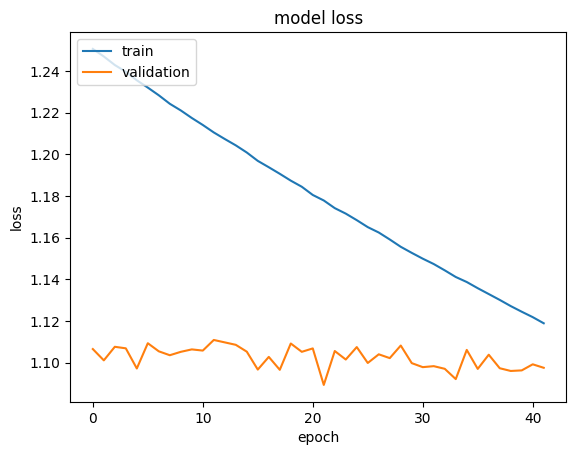

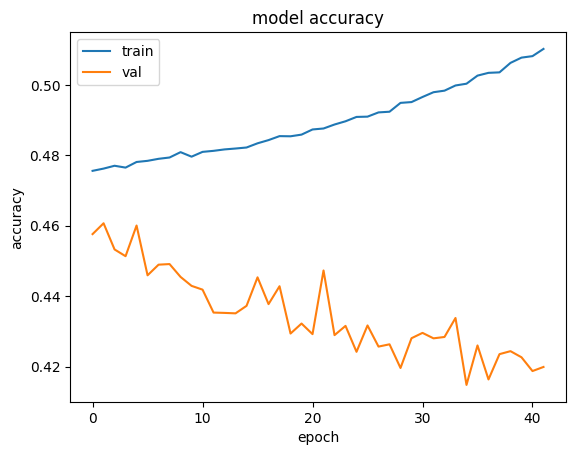

In [14]:
from matplotlib import pyplot as plt
# Plot Train and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot Precision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
test_preds = model.predict(test_data,batch_size=1)

151580/151580 [==============================] - 203s 1ms/step


In [16]:
preds_mask = np.zeros((test_preds.shape))
# (np.max(test_preds)-np.min(test_preds))/2)
preds_mask[np.where(test_preds >= 0.5)] = 1

In [17]:
print(np.max(test_preds))
print(np.min(test_preds))

0.3855012
7.924067e-05


In [18]:
# Calculate precision and recall
predicted = preds_mask.flatten()
actual = test_labels.flatten()
TP = np.count_nonzero(predicted * actual)
TN = np.count_nonzero((predicted - 1) * (actual - 1))
FP = np.count_nonzero(predicted * (actual - 1))
FN = np.count_nonzero((predicted - 1) * actual)

precision = TP/(TP + FP)
recall = TP/(TP + FN)

print("True Positive: ",TP)
print("True Negative: ",TN)
print("False Positive: ",FP)
print("False Negative: ",FN)
print("Accuracy: ", (TP+TN)/(TP + TN + FP + FN))
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", precision*recall/(precision+recall))

ZeroDivisionError: division by zero

In [ ]:
# test_scores = np.zeros((test_preds.shape[0]))
# for i in range(test_preds.shape[0]):
#   # Calculate RMSE
#   test_scores[i] = np.sqrt(np.sum(np.square(test_preds[i] - test_data[i])))

In [ ]:
# threshold = 25
# anomaly_or_not = np.zeros(test_scores.shape)
# anomaly_or_not[np.where(test_scores >= threshold)] = 1

In [ ]:
# print(test_labels)
# print(anomaly_or_not)

In [19]:
import torch
import torch.nn as nn

# Define the model
class Tabular_net_model(nn.Module):
  def __init__(self,input,device):
    super(Tabular_net_model, self).__init__()
    self.device = device

    self.layer = nn.Sequential(
        nn.Linear(4,16),
        nn.ReLU(),
        nn.Linear(16,32),
        nn.ReLU(),
        nn.Linear(32,64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,4)
    )
  def forward(self,x):
    x = x.type(torch.FloatTensor).to(self.device)
    return self.layer(x)

In [8]:
from torchsummary import summary
batch_size = 128
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
input_shape = (4,)
num_classes = 4
model = Tabular_net_model(input_shape,device)
model = model.to(device)
summary(model,input_shape,batch_size)

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [128, 16]              80
              ReLU-2                  [128, 16]               0
            Linear-3                  [128, 32]             544
              ReLU-4                  [128, 32]               0
            Linear-5                  [128, 64]           2,112
              ReLU-6                  [128, 64]               0
           Dropout-7                  [128, 64]               0
            Linear-8                  [128, 32]           2,080
              ReLU-9                  [128, 32]               0
           Linear-10                  [128, 16]             528
             ReLU-11                  [128, 16]               0
           Linear-12                   [128, 4]              68
Total params: 5,412
Trainable params: 5,412
Non-trainable params: 0
----------------------------

In [9]:
import torch
#  Create class for formatting data
class AnomalyData(torch.utils.data.Dataset):
    def __init__(self,input_shape,batch_size,input_data,input_label):
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.input_data = input_data
        self.input_label = input_label

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        # Input data
        data = self.input_data[idx]
        x = data

        # Input label
        label = self.input_label[idx]
        y = label

        return torch.tensor(x), torch.tensor(y)

In [46]:
import torch.nn.functional as F

#  Loss function
def CenterDistLoss(outputs,center,device):
  dist = torch.sum((outputs.to(device) - center.to(device)) ** 2, dim=1)
  return torch.mean(dist)

In [47]:
def init_center_c(train_loader, model, device, eps=0.1):
  """Initialize hypersphere center c as the mean from an initial forward pass on the data."""

  n_samples = 0
  c = torch.zeros([4,]).to(device)

  model.eval()
  with torch.no_grad():
      for data in train_loader:
          # get the inputs of the batch
          inputs, _ = data
          inputs = inputs.to(device)
          # print(tf.shape(inputs))
          outputs = model(inputs)
          n_samples += outputs.shape[0]
          c += torch.sum(outputs, dim=0)

  c /= n_samples

  # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.
  c[(abs(c) < eps) & (c < 0)] = -eps
  c[(abs(c) < eps) & (c > 0)] = eps

  return c

In [54]:
class AnomalyTrainer():
  def __init__(self,epochs,model,train_dataloader,val_dataloader,test_dataloader,optimizer,loss_function,center,device):
    self.epochs = epochs
    self.model = model
    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader
    self.test_dataloader = test_dataloader
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.center = center
    self.device = torch.device(device)
    # self.model = self.model.to(self.device)
    self.model = model

  def train(self):
    train_losses = []
    val_losses = []
    #  For each Epoch, do the following:
    for j in range(self.epochs):
      running_loss = 0.0
      for i, data in enumerate(self.train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        outputs = self.model(inputs.to(self.device))
        loss = self.loss_function(outputs,self.center,self.device)
        loss.backward()
        self.optimizer.step()

        #  Update loss
        running_loss += loss.item()

      # Print statistics once done
      print(f' Epoch [{j + 1}/{self.epochs}] train_loss: {running_loss / i:.3f}')
      train_losses.append(running_loss / i)
      running_loss = 0.0

      # Validating
      val_loss = 0.0
      for i, data in enumerate(self.val_dataloader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        self.optimizer.zero_grad()

        # Forward, Backward, Optimize
        outputs = model(inputs.to(self.device))
        loss = self.loss_function(outputs,labels,self.device)
        val_loss += loss.item()

      #  Print statistics once done
      print(f' Epoch [{j + 1}/{self.epochs}] val_loss: {val_loss / i:.3f}')
      val_losses.append(val_loss / i)
      val_loss = 0.0
    print('Finished Training')
    # Plot the training and validation losses
    plt.plot(range(1, self.epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, self.epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

  def test(self):
    test_scores = np.zeros((test_data.shape[0]))
    with torch.no_grad():
      for i,data in enumerate(self.test_dataloader):
        # reconstruct test set
        input, labels = data
        outputs = self.model(input.to(self.device))
        outputs = outputs.cpu().numpy()

        #  Calculate RMSE
        test_scores[i] = np.sqrt(np.sum(np.square(outputs - self.center.cpu().numpy())))



In [64]:
def run_experiment():
    batch_size = 128
    input_shape = (4,)
    num_classes = 4

    # Load training set
    train_set = AnomalyData(input_shape,batch_size=batch_size,input_data=train_data, input_label=train_label)
    train_dataloader = torch.utils.data.DataLoader(
                train_set,
                batch_size,
                num_workers=1,
                shuffle=True,
            )

    # Load validation set
    val_set = AnomalyData(input_shape, batch_size=batch_size, input_data=val_data, input_label=val_labels)
    val_dataloader = torch.utils.data.DataLoader(
                val_set,
                batch_size,
                num_workers=1,
                shuffle=True,
            )

    # Load testing set
    test_set = AnomalyData(input_shape, batch_size=batch_size, input_data=test_data, input_label=test_labels)
    test_dataloader = torch.utils.data.DataLoader(
                test_set,
                batch_size=1,
                num_workers=1,
                shuffle=True,
            )
    # Get device type
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Get model
    model = Tabular_net_model(input_shape,device)

    # Set device for model
    model.to(device)

    # Initialize hypersphere center
    center = init_center_c(train_dataloader, model, device, eps=0.1)

    #  Set Model Params
    epochs = 30

    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2,weight_decay=1e-6,amsgrad=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,20], gamma=0.1)

    #  Set Loss
    loss_fn = CenterDistLoss

    # Initialize trainer class
    running = AnomalyTrainer(epochs,model,train_dataloader,val_dataloader,test_dataloader,optimizer,loss_function=loss_fn,center=center,device=device)

    # Train Model
    running.train()

    # Test Model
    running.test()

In [65]:
run_experiment()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tor

 Epoch [1/30] train_loss: 0.008


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [1/30] val_loss: 44.752


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [2/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [2/30] val_loss: 44.828


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [3/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [3/30] val_loss: 44.752


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [4/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [4/30] val_loss: 44.703


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [5/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [5/30] val_loss: 44.719


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [6/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [6/30] val_loss: 44.684


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [7/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [7/30] val_loss: 44.752


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [8/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [8/30] val_loss: 44.763


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [9/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [9/30] val_loss: 44.697


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [10/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [10/30] val_loss: 44.715


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [11/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [11/30] val_loss: 44.762


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [12/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [12/30] val_loss: 44.725


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [13/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [13/30] val_loss: 44.688


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [14/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [14/30] val_loss: 44.765


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Epoch [15/30] train_loss: 0.000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798c01c3cf70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


KeyboardInterrupt: 

In [86]:
from sklearn.metrics import roc_auc_score
print(test_scores)
test_auc = roc_auc_score(test_labels, test_scores)
print("Test_auc:", test_auc)

[1694.6035504 1914.0877869 1585.3348802 ...    0.           0.
    0.       ]
Test_auc: 0.4996422164873231


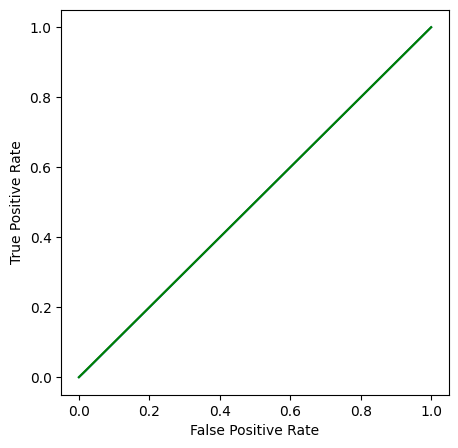

In [87]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_test = test_labels
y_pred = test_scores
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
# plot_sklearn_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
plot_sklearn_roc_curve(y_test, y_pred)

In [76]:
# Calculate precision and recall
from sklearn.metrics import precision_score, recall_score, accuracy_score
precision = precision_score(np.squeeze(test_labels), test_scores)
recall = recall_score(np.squeeze(test_labels), test_scores)
accuracy = accuracy_score(np.squeeze(test_labels), test_scores)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

ValueError: Classification metrics can't handle a mix of binary and continuous targets